In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud

# from tqdm.notebook import tqdm
import spacy, nltk, json, re, emoji, csv, tweepy, time, itertools   # also run:  python -m spacy download 'en_core_web_md'
!spacy download 'en_core_web_md'
from datetime import datetime
from collections import Counter

from afinn import Afinn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('sentiwordnet')
nltk.download('wordnet')

import gensim
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV,  StratifiedKFold, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, log_loss, accuracy_score, classification_report

import tensorflow as tf
import tensorflow.keras.models
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
import tensorboard

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Twitter Authorization Process

In [ ]:
# Exploring json output to determine information to mine from tweets

# twt = [tweet for tweet.full_text in test_tweets]
# print(json.dumps(twt[0]._json, indent = 4, sort_keys = True))


# twt = pd.DataFrame([(twt.full_text, twt.source) for twt in test_tweets])
# twt

In [ ]:
class TweetMiner():

    twitter_auth_keys = {
            # Place Access and Consumer Keys
    }
    
    def __init__(self, twitter_auth_keys = twitter_auth_keys, count = 100):

        auth = tweepy.OAuthHandler(twitter_auth_keys['consumer_key'], twitter_auth_keys['consumer_key_secret'])
        auth.set_access_token(twitter_auth_keys['access_token'], twitter_auth_keys['access_token_secret'])
        api = tweepy.API(auth, wait_on_rate_limit = True)
        self.api = api
        self.count = count
        try:
            api.verify_credentials()
            print("Authentication OK")
        except:
            print("Error During Authentication")
            
            
    def df_miner(self, api_cursor):
        data = []
        for tweet in api_cursor:     # repalce with tqdm(api_cursor) for progress bar - deppnote does support ipywidgets yet
            mined_data = {
                'created_at'      : tweet.created_at,
                'user_name'       : tweet.user.name,
                'screen_name'     : tweet.user.screen_name,
                'text'            : tweet.full_text,
                'user_description': tweet.user.description,
                'retweeted'       : tweet.retweeted,
                'geo'             : tweet.geo,
                'location'        : tweet.user.location,
                'source'          : tweet.source 
              }
            data.append(mined_data)
        data = pd.DataFrame(data)
        data = data.sort_values('created_at').reset_index(drop = True)   
        return data

    
    
    def tweet_search(self, query = 'recession', **kwargs):
        gathered_tweets = tweepy.Cursor(self.api.search, q = query, count = self.count, tweet_mode = 'extended', **kwargs).items(self.count)
        df = self.df_miner(gathered_tweets)
        return df


        
    def user_tweet_search(self, user = 'Wendys', **kwargs):
        gathered_tweets = tweepy.Cursor(self.api.user_timeline, screen_name = user, count = self.count, lang = 'en', tweet_mode = "extended", 
                                **kwargs).items(self.count)
        df = self.df_miner(gathered_tweets)    
        return df


##  Gather tweets from Twitter

In [ ]:
# test_miner = TweetMiner(count = 10)
# pd.DataFrame(test_miner.user_tweet_search(user = 'NYTimesBusiness'))

In [ ]:
miner = TweetMiner(count = 5000)

Authentication OK


In [ ]:
# start_time = time.time()

# raw_tweets = pd.DataFrame(miner.user_tweet_search(user = 'NYTimesBusiness'))
# users_to_mine = ['WSJecon', 'WSJmarkets', 'CNNbusiness', 'FOXBusiness', 'ReutersBiz', 
#                     'FinancialTimes', 'Business', 'YahooFinance', 'WashpostBiz', 'BBCBusiness',
#                     'MarketWatch', 'ReutersGMF', 'Markets', 'NPRbusiness']



# for user in users_to_mine:
#      raw_tweets = raw_tweets.append(miner.user_tweet_search(user = user), ignore_index = True)

# raw_tweets.to_csv('raw_tweets.csv', index = False, encoding = 'utf-8')

# print('---- Total time to execute: %s seconds ----' %(time.time() - start_time), '\n \n', 
#      ' Number of Total Tweets Gathered: %s' %len(raw_tweets))


In [ ]:
raw_tweets = pd.read_csv('./data/raw_tweets.csv', header = 0)
raw_tweets['created_at'] = raw_tweets['created_at'].apply(lambda dt: datetime.strptime(dt, '%Y-%m-%d %H:%M:%S'))
print('Number of Tweets in CSV:', str(len(raw_tweets)))
raw_tweets.head()

Number of Tweets in CSV: 48368


,created_at,user_name,screen_name,text,user_description,retweeted,geo,location,source
0,2020-01-15 10:39:04,NYT Business,nytimesbusiness,"On paper, Japan has exceptionally generous pat...","Financial, tech, media and other business news...",False,NaN,"New York, NY",SocialFlow
1,2020-01-15 11:08:01,NYT Business,nytimesbusiness,People watch with their kids. They watch becau...,"Financial, tech, media and other business news...",False,NaN,"New York, NY",SocialFlow
2,2020-01-15 11:43:05,NYT Business,nytimesbusiness,The U.S. fears China could use American trade ...,"Financial, tech, media and other business news...",False,NaN,"New York, NY",SocialFlow
3,2020-01-15 12:13:03,NYT Business,nytimesbusiness,"To get access to your secret data file, you ma...","Financial, tech, media and other business news...",False,NaN,"New York, NY",SocialFlow
4,2020-01-15 12:43:03,NYT Business,nytimesbusiness,Some malls have gone out of business and have ...,"Financial, tech, media and other business news...",False,NaN,"New York, NY",SocialFlow


In [ ]:
tweet_types = pd.Series([type(item) for item in raw_tweets.text])
tweet_types.value_counts()

<class 'str'>    48368
dtype: int64

## Preprocess text

In [ ]:
# Drop retweets, separate Date and Time
raw_tweets['date'], raw_tweets['time'] = raw_tweets['created_at'].apply(lambda x:x.date()), raw_tweets['created_at'].apply(lambda x:x.time())
raw_tweets = raw_tweets.drop(['created_at'], axis = 1)
col_names = raw_tweets.columns.to_list()
new_cols = col_names[-2:] + col_names[:-2]
raw_tweets = raw_tweets[new_cols]
raw_tweets = raw_tweets.sort_values(['date', 'time'])
raw_tweets = raw_tweets.astype(str)
raw_tweets = raw_tweets.reset_index(drop = True)



# Find all retweets from list of tweets
is_retweet = list(bool(re.search(r'^RT', tweet)) for tweet in raw_tweets.text)
retweets = raw_tweets[is_retweet]
tweets = raw_tweets.drop(index = retweets.index)
tweets = tweets.reset_index(drop = True)
retweets = retweets.reset_index(drop = True)



print('Number of Total Tweets: %d \nNumber of ReTweets: %d \nNumber of Tweets not RT %d' 
      %(len(raw_tweets), len(retweets), len(tweets)))

raw_tweets.head()

Number of Total Tweets: 48368 
Number of ReTweets: 7002 
Number of Tweets not RT 41366


,date,time,user_name,screen_name,text,user_description,retweeted,geo,location,source
0,2016-01-22,15:19:42,Global Markets Forum,ReutersGMF,.@standardpoors chief economist tells @Reuters...,The team behind Reuters 24-hour community for ...,False,nan,nan,TweetDeck
1,2016-01-22,15:21:45,Global Markets Forum,ReutersGMF,.@standardpoors chief economist tells @Reuters...,The team behind Reuters 24-hour community for ...,False,nan,nan,TweetDeck
2,2016-01-22,15:33:57,Global Markets Forum,ReutersGMF,.@MauricioCard set to take your questions in @...,The team behind Reuters 24-hour community for ...,False,nan,nan,TweetDeck
3,2016-01-22,16:36:03,Global Markets Forum,ReutersGMF,Colombian FinMin @MauricioCard takes your ques...,The team behind Reuters 24-hour community for ...,False,nan,nan,TweetDeck
4,2016-01-22,16:59:36,Global Markets Forum,ReutersGMF,.@MauricioCard tells @ReutersGMF reducing Colo...,The team behind Reuters 24-hour community for ...,False,nan,nan,TweetDeck


In [ ]:
# for tweet in tweets.text[0:1000]:
#     print(tweet, '\n\n')


In [ ]:
# Preprocess Text to remove hastags,, tags, links, empty lines, and emojis
remove_punctuation = re.compile("[#.:,-?!()]")
remove_mentions = re.compile("(@[\w']+)")
remove_links = re.compile('(https?://.+)')
remove_empty_lines = re.compile('\n')
replace_ellipses = re.compile(r'(\.{3,}|\u2026)')
replace_double_space = re.compile('\s{2,}')
remove_emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F912-\U0001F9D0"
                           "]+", flags=re.UNICODE)


def preprocess_text(text):
    text = remove_mentions.sub('', text)
    text = remove_links.sub('', text)
    text = remove_empty_lines.sub(' ', text)
    text = remove_emojis.sub('', text)
    text = replace_ellipses.sub('.', text)
    text = remove_punctuation.sub('', text)
    text = replace_double_space.sub(' ', text)
    return text.lower()


# cleaned_tweets = tweets.copy()
# cleaned_raw_tweets = raw_tweets.copy()
# cleaned_retweets = retweets.copy()

# cleaned_tweets.text = cleaned_tweets['text'].apply(lambda tweet: preprocess_text(tweet))
# cleaned_raw_tweets.text = cleaned_raw_tweets['text'].apply(lambda tweet: preprocess_text(tweet))
# cleaned_retweets.text = cleaned_retweets['text'].apply(lambda tweet: preprocess_text(tweet))

In [ ]:
# cleaned_raw_tweets.to_csv('./data/cleaned_raw_tweets.csv', index = False, encoding = 'utf-8', header = True)
# cleaned_tweets.to_csv('./data/cleaned_tweets.csv', index = False, encoding = 'utf-8', header = True)
# cleaned_retweets.to_csv('./data/cleaned_retweets.csv', index = False, encoding = 'utf-8', header = True)


In [ ]:
cleaned_tweets = pd.read_csv('./data/cleaned_tweets.csv', encoding = 'utf-8').astype('str')
cleaned_retweets = pd.read_csv('./data/cleaned_retweets.csv', encoding = 'utf-8').astype('str')
cleaned_raw_tweets = pd.read_csv('./data/cleaned_raw_tweets.csv', encoding = 'utf-8').astype('str')

In [ ]:
cleaned_tweets.text.head()

0     chief economist tells global economy likely t...
1     chief economist tells "everyone's forecast is...
2             set to take your questions in any minute
3            colombian finmin takes your questions in 
4     tells reducing colombia's current account def...
Name: text, dtype: object

In [ ]:
# Was getting an error from importing the saved cleaned tweet files. Some were being imported as type float for some reason
types = pd.Series([type(item) for item in cleaned_raw_tweets.text])
print(types.value_counts())
# cleaned_tweets.loc[types[types == float].index.to_list()]

<class 'str'>    48368
dtype: int64


## Word Cloud

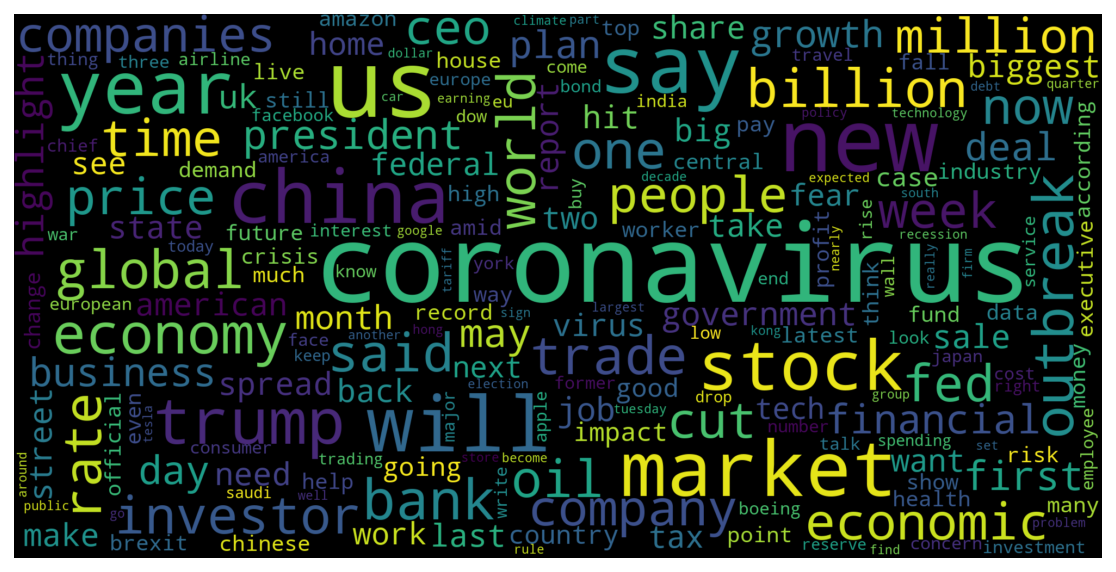

In [ ]:
text = []
for txt in cleaned_tweets['text']:
    text.append(txt)
    
text = pd.Series(text).str.cat(sep = ' ').lower()

# Plot Word Cloud
plt.figure(figsize = (12, 5))
wordcloud = WordCloud(width = 2000, height = 1000, max_font_size = 200, collocations = False).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# the words economy and recession were bound to be the most common words since the tweets were scrapped using them as key words
# to get a better view of other key terms, it may be better to drop them

**Interestingly, coronavirus seems to be mentioned the most. Seems reasonable since it is currently scaring off investors and causing the indeces to plunge.**


## Tokenize Text

In [ ]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_md')

In [ ]:
start_time = time.time()

docs = list(nlp.pipe(cleaned_tweets.text))

cleaned_docs = []
for doc in docs:
    cleaned_docs.append([token for token in doc if token.is_alpha == True or token.is_stop == True])


print('---- Total time to execute: %s seconds ----' %(time.time() - start_time))

---- Total time to execute: 267.41606616973877 seconds ----


In [ ]:

len([x for x in cleaned_docs if x ==[]])

1

In [ ]:
blanks = []
for i in range(len(docs)):
    if cleaned_docs[i] == []:
        blanks.append(i)

print(blanks, '\n')

print('Number of total cleaned docs: %i' %len(cleaned_docs))
print('Number of blank docs: %i' %len(blanks))
print('Number of total non-blank cleaned docs: %i' %(len(cleaned_docs) - len(blanks)))


[26841] 

Number of total cleaned docs: 41366
Number of blank docs: 1
Number of total non-blank cleaned docs: 41365


In [ ]:
cleaned_docs = [x for x in cleaned_docs if x != []]
len(cleaned_docs)

41365

In [ ]:
len([x for x in cleaned_docs if x ==[]])

0

## Word Counts

In [ ]:
# Find the Word Count

words = list(itertools.chain.from_iterable(cleaned_docs))

no_stops = [token.text for token in words if token.is_stop == False]
words = [token.text for token in words]

word_freq = Counter(no_stops)
word_freq = pd.DataFrame(word_freq.most_common(), columns = ['text', 'counts'])
word_freq[:20]

,text,counts
0,coronavirus,6123
1,new,3156
2,china,2682
3,says,2549
4,trump,2008
5,year,1778
6,market,1728
7,economy,1526
8,outbreak,1436
9,world,1329


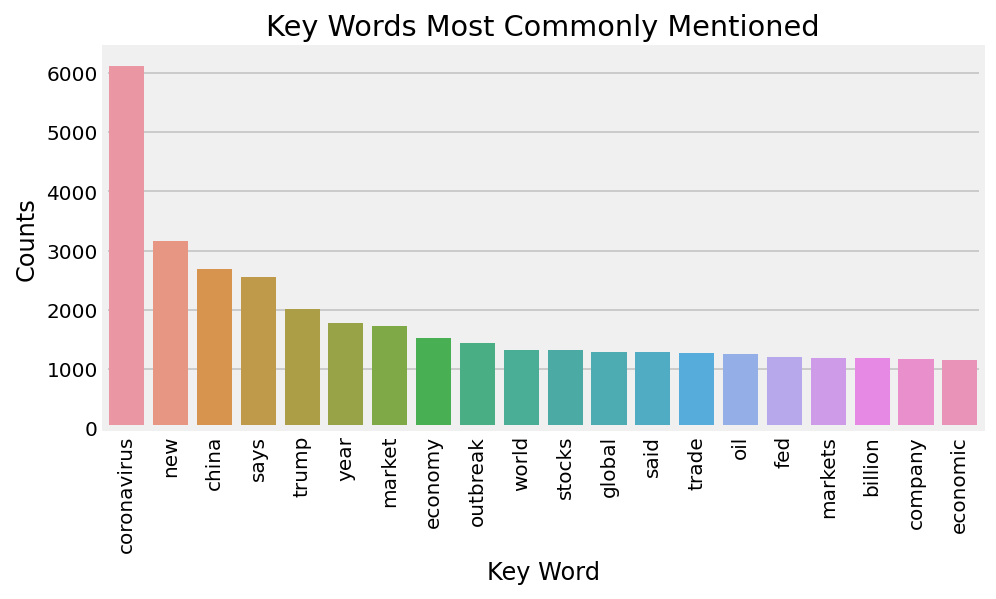

In [ ]:
plt.figure(figsize = (7, 3.5))
sns.barplot(x = word_freq.text[:20], y = word_freq.counts[:20])
plt.xticks(rotation = 90)
plt.title('Key Words Most Commonly Mentioned')
plt.xlabel('Key Word')
plt.ylabel('Counts')
plt.show()


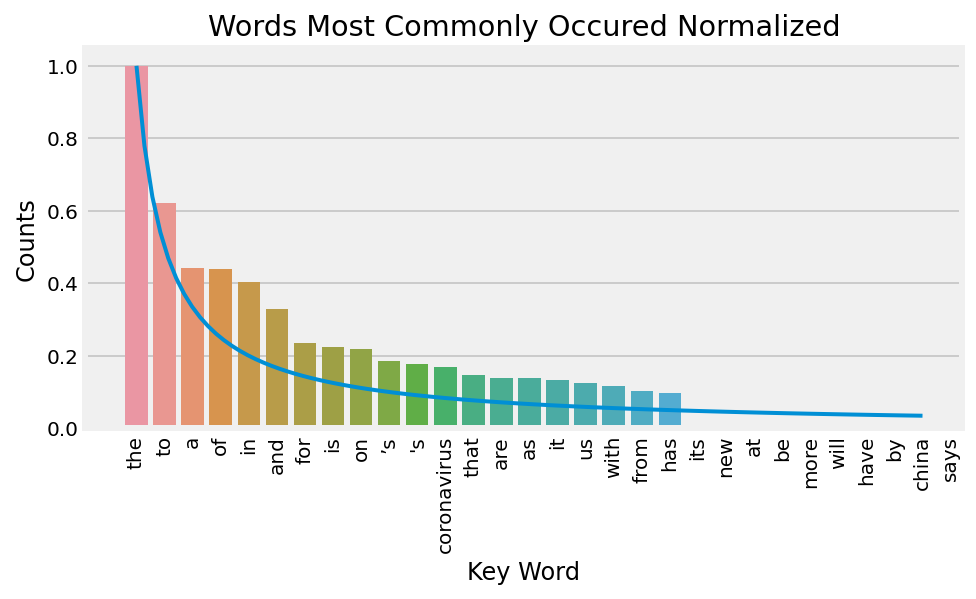

In [ ]:
# Zipf's Law


all_words_freq = pd.DataFrame(Counter(words).most_common(), columns = ['text', 'counts'])
all_wf_norm = all_words_freq.copy()

all_wf_norm.counts = all_wf_norm.counts / all_wf_norm.counts[0]

plt.figure(figsize = (7, 3.5))
sns.barplot(x = all_wf_norm.text[:30], y = all_wf_norm.counts[:20])
x = np.linspace(1, 29, 100)
y = 1/x
plt.plot(x - 1, y, linewidth = 2)
plt.xticks(rotation = 90)
plt.title('Words Most Commonly Occured Normalized')
plt.xlabel('Key Word')
plt.ylabel('Counts')
plt.show()

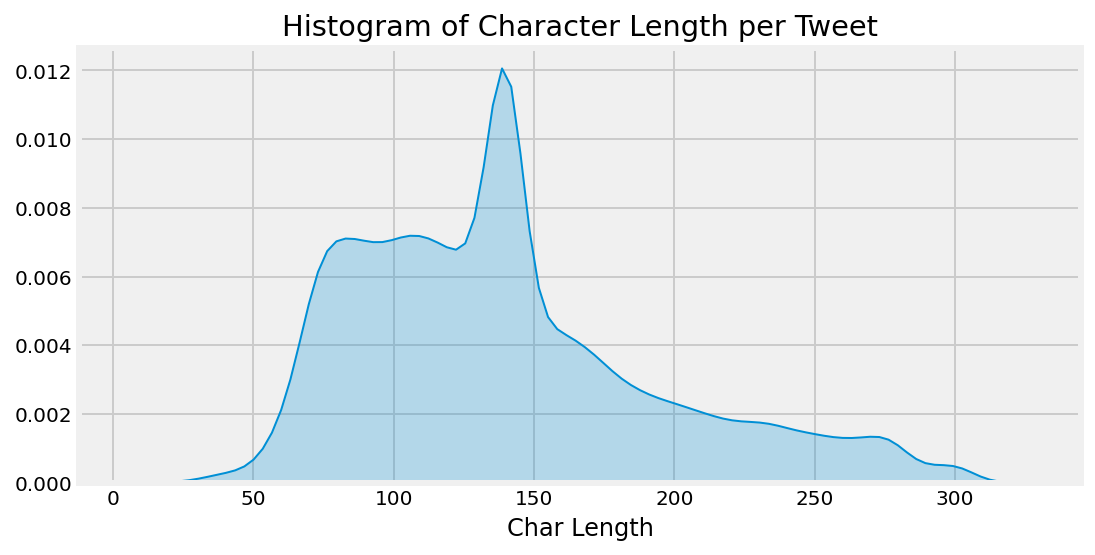

In [ ]:
plt.figure(figsize = (8, 4))
sns.kdeplot([len(tweet) for tweet in raw_tweets['text']], shade = True, linewidth = 1);
plt.title('Histogram of Character Length per Tweet')
plt.xlabel('Char Length')
plt.show()


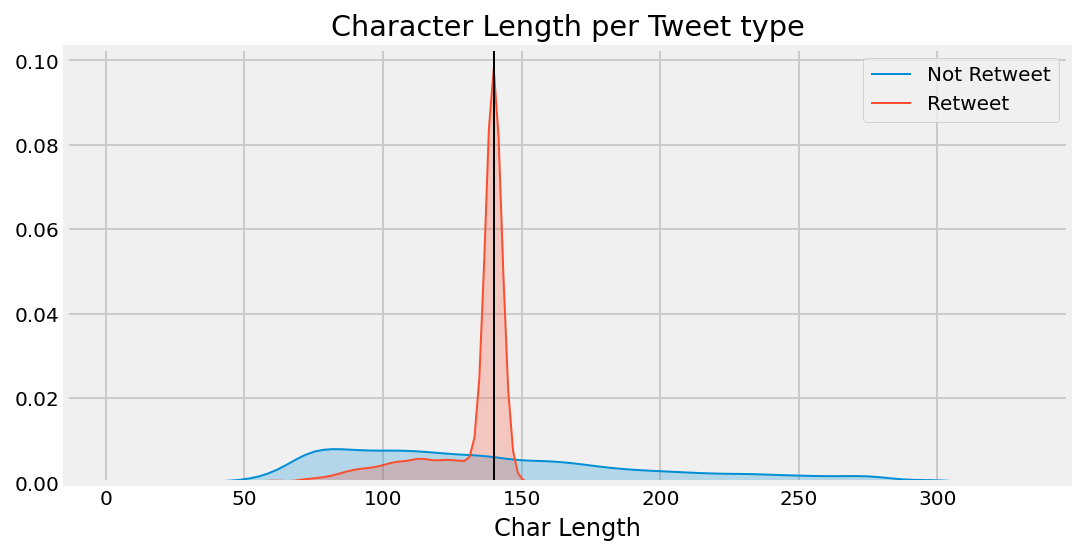

The average length for a retweet is: 131.6506712367895 They seem to get truncated at about Twitter's original 140 character limit.


In [ ]:
plt.figure(figsize = (8, 4))
sns.kdeplot([len(tweet) for tweet in tweets['text']], shade = True, label = 'Not Retweet', linewidth = 1);
sns.kdeplot([len(tweet) for tweet in retweets['text']], shade = True, label = 'Retweet', linewidth = 1);
plt.axvline(140, color = 'black', linewidth = 1)
plt.title('Character Length per Tweet type')
plt.xlabel('Char Length')
plt.show()
print('The average length for a retweet is:', np.mean([(len(tweet)) for tweet in retweets['text']]),
     "They seem to get truncated at about Twitter's original 140 character limit.")

# Time Plot

In [ ]:
date_counts = tweets['date'].value_counts().sort_index()
fig = go.Figure([go.Scatter(x = tweets['date'].unique(), y = date_counts)])
fig.update_layout(title = 'Tweets Frequency', xaxis_rangeslider_visible = True)
fig.show()

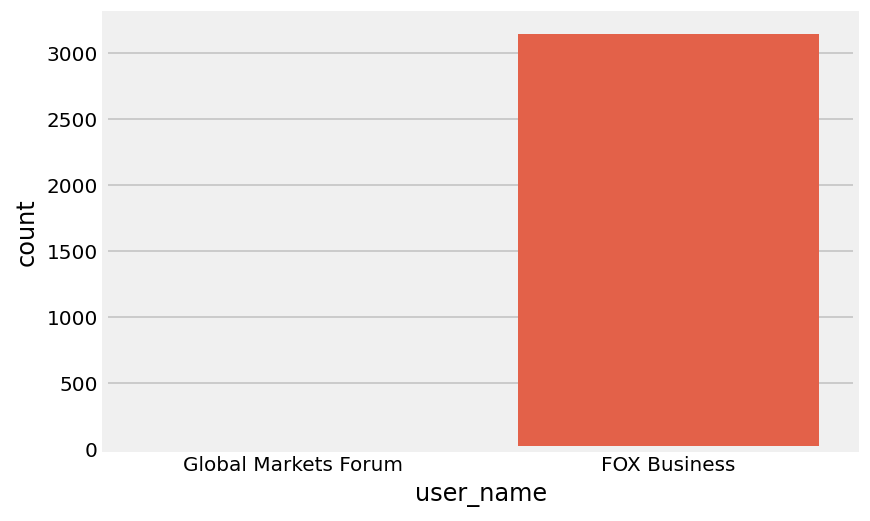

In [ ]:
anomaly = tweets[(tweets['date'] >= '2018-10-14') & (tweets['date'] <= '2018-11-09')]

sns.countplot(anomaly['user_name'])
plt.show()

There is an odd spike from mid October to November in the frequency of tweets, the vast majority coming from Fox Business. After a little googling, 
there doesn't seem to be any major financial news breaking around that time. A few of the tweets mentioned crypto crashing but nothing major. The only news I found
that was noteworthy in the timeframe was about the murder of Jamal Khashoggi and the escalation of tensions between the U.S. and Saudi Arabia. But it doesn't explain
the sudden spike of tweets from only Fox Business and not the other major financial news outlets. It may have to do with how Twitter allows users to collect tweets,
meaning more recent tweets may take priority thus providing an abundance of them and a shortage of older tweets. TBD...

Further investigation found something I previously missed when gathering the data. It appears Fox Business's Twitter account has been inactive since 2018, exaplining the
spike in the number of tweets.


Unsuprisingly, the vast majority of tweets come from January 2020 and onward. Again, it may be partly due to how the request for the tweets was fulfilled by Twitter, but 
likely mainly due to how the COVID-2019 virus is scaring investors and causing the markets to drop and become more volatile. 


In [ ]:
users = tweets['screen_name'].unique()[5:]
select_users = tweets[tweets['screen_name'].isin(users)]
users_dates = select_users.groupby(['screen_name', 'date']).count()['time'].to_frame()
users_dates.columns = ['count']
users_dates = users_dates.reset_index()


fig = px.line(users_dates, x = 'date', y = 'count', color = 'screen_name')
fig.update_layout(title = 'Tweet Frequency per Account', xaxis_rangeslider_visible = True)
fig.show()

Plotting how often a news organization tweets per day answers reveals an trend and how the tweets requested are received from Twitter. 
If an twitter user tends to tweet often, the tweets gathered tend to be more recent. Explains why the tweets of some users tend to go further back in
time than some others (they tend to tweet less).

# Doc2Vec

- needs exploration

In [ ]:
# Messing around with the Spacy visualizer

# test_doc = nlp(cleaned_tweets.text[100])
# spacy.displacy.render(test_doc, style = 'ent', jupyter = True)

In [ ]:
for doc in cleaned_docs[:2]:
    print(' '.join([(token.lemma_ if token.lemma_ != "-PRON-" else token.text) for token in doc if token.is_stop == False]))

chief economist tell global economy likely continue grow cpct despite bit rebalancing go
chief economist tell forecast chase oil price different


In [ ]:
spacy.prefer_gpu()

start_time = time.time()

lemma_docs = []
for doc in cleaned_docs:
    lemma_docs.append(' '.join([(token.lemma_ if token.lemma_ != "-PRON-" else token.text) for token in doc if token.is_stop == False]))

lemma_docs = list(nlp.pipe(lemma_docs))

print('---- Total time to execute: %s seconds ----' %(time.time() - start_time))

---- Total time to execute: 115.18430924415588 seconds ----


In [ ]:
train_set, val_set = train_test_split(lemma_docs, test_size = 5000, random_state = 42)
tagged_train = [TaggedDocument([word.text for word in doc], ['train' + '_%s' % i]) for i, doc in enumerate(train_set)]


In [ ]:
import multiprocessing

# cores = multiprocessing.cpu_count()

# dm_model = Doc2Vec(dm = 1, vector_size = 200, min_count = 3, epochs = 30, workers = cores, seed = 42, alpha = 0.05, min_alpha = 0.001)
# dm_model.build_vocab(tagged_train)

In [ ]:
# start_time = time.time()

# dm_model.train(tagged_train, total_examples = dm_model.corpus_count, epochs = dm_model.epochs)
# dm_model.save('dm_model')

# print('---- Total time to execute: %s seconds ----' %(time.time() - start_time))

In [ ]:
dm_model = Doc2Vec.load('./models/nlp models/dm_model')

In [ ]:
dm_model.wv.most_similar('economy')
# dm_model.infer_vector([token.text for token in test_set[0]])   # to "predict" the paragraph vector for a new tweet

[('economic', 0.7207037210464478),
 ('recession', 0.6659744381904602),
 ('modest', 0.5987817049026489),
 ('market', 0.5922441482543945),
 ('coronavirus', 0.5887203216552734),
 ('sector', 0.5802310705184937),
 ('outbreak', 0.5655859112739563),
 ('pandemic', 0.5629265904426575),
 ('manufacturing', 0.5598702430725098),
 ('factory', 0.5186828970909119)]

In [ ]:
dm_model.wv.most_similar('virus')

[('coronavirus', 0.8227459192276001),
 ('covid', 0.6431212425231934),
 ('viral', 0.5927944779396057),
 ('region', 0.5651749968528748),
 ('illness', 0.5579205751419067),
 ('novel', 0.5516122579574585),
 ('deadly', 0.5470724105834961),
 ('china', 0.5455681085586548),
 ('outbreak', 0.5437846183776855),
 ('dependence', 0.5412525534629822)]

## K Means Clustering

In [0]:
word_vectors = dm_model_before.wv
np.shape(word_vectors.vectors)

In [0]:
start_time = time.time()

kmeans = KMeans(n_clusters = 3, random_state = 42, max_iter = 1000)
kmeans.fit(word_vectors.vectors)

print('---- Total time to execute: %s seconds ----' %(time.time() - start_time))

In [0]:
word_vectors.similar_by_vector(kmeans.cluster_centers_[0], topn = 10)

# news related, meaning refers to people involved in media, 
# such as Rupert, likely referring to Rupert Murdoch, or topics trending in the news.

In [0]:
word_vectors.similar_by_vector(kmeans.cluster_centers_[1], topn = 15)

# I have no idea what this cluster corresponds to. 
# The words do not seem to have anything in common

In [0]:
word_vectors.similar_by_vector(kmeans.cluster_centers_[2], topn = 15)

# Economy-related terms

Not very useful, did not produce the results desired. It did seperate by terms that are closely related, which was expected. 

# Scoring with Lexicons

In [0]:
syn_word = swn.senti_synsets('ultimate', pos = 'n')
syn_word = list(syn_word)[0]   # taking first one since most common occurence
print(syn_word, syn_word.pos_score(), syn_word.neg_score(), syn_word.obj_score())

In [ ]:
def pos_tag_converter(tag):
    """
    Convert Spacy POS tag into one taken by sentiwordnet
    """
    if tag == 'NOUN' or tag == 'DET':
        return 'n'
    elif tag == 'ADJ':
        return 'a'
    elif tag == 'VERB':
        return 'v'
    elif tag == 'ADV':
        return 'r'        
    return None


def sentiwn_score(docs):
    scores = []
    word_scores = []
    for doc in docs:
        doc_score = []

        for token in doc:

            pos = pos_tag_converter(token.pos_)

            try:
                if pos == None:
                    doc_score.append([0,0])
                else:
                    synset = swn.senti_synsets(token.text, pos = pos)
                    synset = list(synset)[0]
                    doc_score.append([synset.pos_score(), -synset.neg_score()])
            except:
                    doc_score.append([0,0])

        doc_score = [max(score, key = abs) for score in doc_score]
        word_scores.append(doc_score)
        scores.append(sum(doc_score))   # sum of score per word dividied by total possible score to normalize
    
    class_target = np.sign(scores)
    return class_target, scores



afinn = Afinn()

def afinn_score(docs):
    scores = []
    word_scores = []
    for doc in docs:
        doc_score = [afinn.score(token.text) for token in doc]
        word_scores.append(doc_score)
        scores.append(sum(doc_score))

    class_target = np.sign(scores)
    return class_target, scores

In [ ]:
# Extract sign of lexicon score to use as class for model classification positive, neutral, or negative

train_swn_target, train_swn_score = sentiwn_score(train_set)
train_afn_target, train_afn_score = afinn_score(train_set)

val_swn_target, val_swn_score = sentiwn_score(val_set)
val_afn_target, val_afn_score = afinn_score(val_set)

In [ ]:
print("Train Set's Values per Class based on SentiWordNet Lexicon:\n", pd.Series(train_swn_target).value_counts(), '\n',
        "Train Set's Percents per class based on SentiWordNet Lexicon:\n", pd.Series(train_swn_target).value_counts() / len(train_swn_target))

Train Set's Values per Class based on SentiWordNet Lexicon:
  1.0    14691
-1.0    12042
 0.0     9632
dtype: int64 
 Train Set's Percents per class based on SentiWordNet Lexicon:
  1.0    0.403987
-1.0    0.331143
 0.0    0.264870
dtype: float64


In [ ]:
print("Train Set's Values per based on Afinn Lexicon:\n", pd.Series(train_afn_target).value_counts(), '\n',
        "Train Set's Percents per class based on Afinn Lexicon:\n", pd.Series(train_afn_target).value_counts()/ len(train_afn_target))

Train Set's Values per based on Afinn Lexicon:
 -1.0    12698
 0.0    12086
 1.0    11581
dtype: int64 
 Train Set's Percents per class based on Afinn Lexicon:
 -1.0    0.349182
 0.0    0.332353
 1.0    0.318466
dtype: float64


In [ ]:
print('Val Sets Values per Class based on SentiWordNet Lexicon:\n', pd.Series(val_swn_target).value_counts(), '\n',
        'Val Sets Percents per class based on SentiWordNet Lexicon:\n', pd.Series(val_swn_target).value_counts() / len(val_swn_target))

Val Sets Values per Class based on SentiWordNet Lexicon:
  1.0    2005
-1.0    1682
 0.0    1313
dtype: int64 
 Val Sets Percents per class based on SentiWordNet Lexicon:
  1.0    0.4010
-1.0    0.3364
 0.0    0.2626
dtype: float64


In [ ]:
print('Val Sets Values per based on Afinn Lexicon:\n', pd.Series(val_afn_target).value_counts(), '\n',
        'Val Sets Percents per class based on Afinn Lexicon:\n', pd.Series(val_afn_target).value_counts()/ len(val_afn_target))

Val Sets Values per based on Afinn Lexicon:
 -1.0    1759
 0.0    1712
 1.0    1529
dtype: int64 
 Val Sets Percents per class based on Afinn Lexicon:
 -1.0    0.3518
 0.0    0.3424
 1.0    0.3058
dtype: float64


## Prepare Word Vectors

In [0]:
def get_vectors(model, corpus, test_set = False):
    if test_set == True:        
        text = [[token.text for token in doc] for doc in corpus]
        vecs = np.array([model.infer_vector(words) for i, words in enumerate(text)])
        return pd.DataFrame(vecs)
    vecs = np.asarray([model.docvecs[i] for i, words in enumerate(corpus)])
    return pd.DataFrame(vecs)

train_vecs = get_vectors(dm_model, train_set)
val_vecs = get_vectors(dm_model, val_set, test_set = True)
print('The dimensions of the training set are:', train_vecs.shape,
      '\nThe dimensions of the validation set are:', val_vecs.shape)

##  Multinomial Logisitc Regression

In [0]:
def logit_grid_search(model, train_data, y_true, param_grid, scoring = 'accuracy', cv = 5):
    start_time = time.time()
    grid_search = GridSearchCV(model, param_grid, cv = cv, scoring = scoring, return_train_score = True)
    grid_search.fit(train_data, y_true)
    trained_model = grid_search.best_estimator_
    preds = trained_model.predict(train_data)
    print('---- Total time to execute: %s seconds ----' %(time.time() - start_time)) 

    return trained_model, preds, grid_search



def classif_reports(y_true, y_pred):
    print('Accuracy Score:', accuracy_score(y_true, y_pred))
    # print('\nNum of Values per Class:\n', pd.Series(swn_preds).value_counts())
    swn_report = classification_report(y_true, y_pred, labels = [0, 1, -1], target_names = ['Neut', 'Pos', 'Neg'])
    print('\nClassification Report',swn_report)
    conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize = 'true'), index = ['True Neg', 'True Neut', 'True Pos'], columns = ['Pred Neg', 'Pred Neut', 'Pred Pos'])
    return conf_matrix

### SentiWordNet Multi-Logit

In [0]:
print('SentiWordNet Lexicon with Normal Variable Set')

param_grid = [
    # {'penalty':['elasticnet'], 'solver':['saga'], 'C':[2, 4], 'max_iter':[1000], 'l1_ratio':[0.3, 0.5]},
    {'penalty':['elasticnet'], 'solver':['saga'], 'C':[2], 'max_iter':[500], 'l1_ratio':[0.3]}
]


logit_base = LogisticRegression(multi_class = 'multinomial', random_state = 42)

logit_swn, swn_preds, swn_grid_search = logit_grid_search(logit_base, train_vecs, train_swn_target, param_grid, cv = 3)
pd.Series(swn_preds).value_counts()
classif_reports(train_swn_target, swn_preds)

In [0]:
logit_swn

In [0]:
pd.Series(swn_preds).value_counts()

In [0]:
val_preds = logit_swn.predict(val_vecs)
classif_reports(val_swn_target, val_preds)

### Afinn Multi-Logit

In [0]:
print('Afinn Lexicon with Normal Variable Set')

logit_base = LogisticRegression(multi_class = 'multinomial', random_state = 42)

logit_afn, afn_preds, afn_grid_search = logit_grid_search(logit_base, train_vecs, train_afn_target, param_grid, cv = 3)
print(logit_afn)
classif_reports(train_afn_target, afn_preds)

In [0]:
print(pd.Series(afn_preds).value_counts())
val_preds_afn = logit_afn.predict(val_vecs)
classif_reports(val_afn_target, val_preds_afn)

Making Porgress!! Initially missed that I had the models trained on word vectors from an older doc2vec model using 150 length vectors as representations. Updated the doc2vec to a new model using 200 length vectors. Had a good impact on performance, increasing from an average max of about 40% to now about 50%. Most notably, is solving the previous issue of class bias. The model using the classes deriving from the sentiwordnet lexicon used to have a 

## Dimensional Reduction using PCA

In [0]:
pca = PCA(random_state = 42)
transf_vecs = pd.DataFrame( pca.fit_transform(train_vecs) )
print(pca.explained_variance_ratio_[:20])
pca_ratios = pca.explained_variance_ratio_


In [0]:
threshold = np.where(pca_ratios.cumsum() >= 0.9)[0][0]

sns.lineplot(x = range(len(pca_ratios)), y = pca_ratios.cumsum(), linewidth = 1, label = 'Cumulative Variance')
sns.scatterplot(x = [threshold], y = [0.9], label = '90% Mark', marker = 'x', color = 'red')
sns.lineplot(x = [0, threshold], y = [0.9, 0.9], color = 'red', dashes = True, linewidth = 0.1)
sns.lineplot(x = [threshold, threshold], y = [0, 0.9], color = 'red', dashes = True, linewidth = 0.1)
sns.lineplot(x = [0, len(pca_ratios)], y = [0, 1], linewidth = 1, label = None, color = 'black')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

print(pca_ratios.cumsum()[threshold])

In [0]:
plt.figure(figsize = (5,3))
sns.lineplot(x = range(len(pca_ratios)), y = pca_ratios, linewidth = 1)
plt.title('PCA Variance Percentage')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Component')
plt.show()

In [0]:
print('Using PCA, can reducde to %i dimensions' %(threshold))

reduced_train_vecs = transf_vecs.iloc[:, :threshold]
print('Reduced Training Vecs dimensions:', reduced_train_vecs.shape)

reduced_val_vecs = pd.DataFrame(pca.transform(val_vecs))
reduced_val_vecs = reduced_val_vecs.iloc[:, :threshold]
print('Reduced Val Vecs dimensions:', reduced_val_vecs.shape)


##  Multinomial Logisitc Regression with Dimensional Reduction via PCA

### SentiWordNet

In [0]:
print('SentiWordNet Lexicon with Reduced Variable Set')

logit_base = LogisticRegression(multi_class = 'multinomial', random_state = 42)

logit_swn, swn_preds, swn_grid_search = logit_grid_search(logit_base, reduced_train_vecs, train_swn_target, param_grid, cv = 3)
print(logit_swn)
classif_reports(train_swn_target, swn_preds)

In [0]:
swn_val_preds_reduced = logit_swn.predict(reduced_val_vecs)
classif_reports(val_swn_target, swn_val_preds_reduced)

### Afinn

In [0]:
print('Afinn Lexicon with Reduced Variable Set')

logit_base = LogisticRegression(multi_class = 'multinomial', random_state = 42)

logit_afn, afn_preds, afn_grid_search = logit_grid_search(logit_base, reduced_train_vecs, train_afn_target, param_grid, cv = 3)
print(logit_afn)
classif_reports(train_afn_target, afn_preds)

In [0]:
afn_val_preds_reduced = logit_afn.predict(reduced_val_vecs)
classif_reports(val_afn_target, afn_val_preds_reduced)

## Bayes Classifier with Full Variable Set

### SentiWordNet

In [0]:
# Gaussian Bayes Classifier

gauss_bayes_swnfull = GaussianNB()
gauss_bayes_swnfull.fit(train_vecs, train_swn_target)
gb_preds_sw =  gauss_bayes_swnfull.predict(train_vecs)
print('Bayes SentiWordNet with Full Vars')
classif_reports(train_swn_target, gb_preds_sw)

In [0]:
val_gb_preds_swn = gauss_bayes_swnfull.predict(val_vecs)
classif_reports(val_swn_target, val_gb_preds_swn)

### Afinn

In [0]:
gauss_bayes_afnfull = GaussianNB()
gauss_bayes_afnfull.fit(train_vecs, train_swn_target)
gb_preds_afn =  gauss_bayes_afnfull.predict(train_vecs)
print('Bayes Afinn with Full Vars')
classif_reports(train_afn_target, gb_preds_afn)

In [0]:
val_gb_preds_afn = gauss_bayes_afnfull.predict(val_vecs)
classif_reports(val_swn_target, val_gb_preds_afn)

## Bayes Classifier with Reduced Variable Set

### SentiWordNet

In [0]:
gauss_bayes_swn_red = GaussianNB()
gauss_bayes_swn_red.fit(reduced_train_vecs, train_swn_target)
gb_preds_sw_red =  gauss_bayes_swn_red.predict(reduced_train_vecs)
print('Bayes SentiWordNet with Reduced Vars')
classif_reports(train_swn_target, gb_preds_sw_red)

In [0]:
val_gb_preds_swn_red = gauss_bayes_swn_red.predict(reduced_val_vecs)
classif_reports(val_swn_target, val_gb_preds_swn_red)

### Afinn

In [0]:
gauss_bayes_afn_red = GaussianNB()
gauss_bayes_afn_red.fit(reduced_train_vecs, train_afn_target)
gb_preds_afn_red =  gauss_bayes_afn_red.predict(reduced_train_vecs)
print('Bayes Afinn with Reduced Vars')
classif_reports(train_afn_target, gb_preds_afn_red)

In [0]:
val_gb_preds_afn_red = gauss_bayes_afn_red.predict(reduced_val_vecs)
classif_reports(val_afn_target, val_gb_preds_afn_red)

## K Nearest Neighbor


Takes way too long to train models.

### SWN

In [0]:
# param_grid = [
#     {'n_neighbors':[5, 25, 50], 'weights': ['uniform', 'distance']}
# ]

# knn_swn = KNeighborsClassifier(n_neighbors = 50)
# knn_swn.fit(train_vecs, train_swn_target)
# knn_swn_preds = knn_swn.predict(train_vecs)
# classif_reports(train_swn_target, knn_swn_preds)

In [0]:
# val_knn_swn_preds = knn_swn.predict(val_vecs)
# classif_reports(val_swn_target, val_knn_swn_preds)

### Afinn

In [0]:
# knn_afn = KNeighborsClassifier(n_neighbors = 50)
# knn_afn.fit(train_vecs, train_afn_target)
# knn_afn_preds = knn_afn.predict(train_vecs)
# classif_reports(train_afn_target, knn_afn_preds)

In [0]:
# val_knn_afn_preds = knn_afn.predict(val_vecs)
# classif_reports(val_swn_target, val_knn_afn_preds)

## Neural Network

In [0]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")


def get_run_logdir(model_name):
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S_') + str(model_name)
    return os.path.join(root_logdir, run_id)

In [0]:
def neural_network(num_layers = 2, neurons = 100, dropout_rate = 0.5):

    model = models.Sequential()
    model.add(layers.InputLayer(input_shape = train_vecs.shape[1:]))
    for layer in range(num_layers):
        model.add(layers.Dropout(rate = dropout_rate))
        model.add(layers.Dense(neurons, activation = 'relu'))
    model.add(layers.Dense(3, activation = 'softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

### SentiWordNet

In [0]:
nn_train_swn_target = train_swn_target + 1
nn_val_swn_target = val_swn_target + 1

In [0]:
NN_swn = neural_network(neurons = 100, num_layers = 7, dropout_rate = 0.9)

run_log_dir = get_run_logdir(model_name = 'NN_sentiwordnet_dropout_0.9')

checkpoint_cb = callbacks.ModelCheckpoint('NN_swn.h5', save_best_only = True)
early_stop_cb = callbacks.EarlyStopping(patience = 15, restore_best_weights = True)
tensorboard_cb = callbacks.TensorBoard(run_log_dir)

In [0]:
start_time = time.time()

history = NN_swn.fit(train_vecs, nn_train_swn_target, validation_data = (val_vecs, nn_val_swn_target), 
                        epochs = 100, batch_size = 32, 
                        verbose = 2, callbacks = [checkpoint_cb, early_stop_cb, tensorboard_cb])

print('---- Total time to execute: %s seconds ----' %(time.time() - start_time)) 

In [0]:
NN_swn_train_preds = np.argmax(NN_swn.predict(train_vecs), axis = -1) - 1
classif_reports(train_swn_target, NN_swn_train_preds)

In [0]:
NN_swn_val_preds = np.argmax(NN_swn.predict(val_vecs), axis = -1) - 1
classif_reports(val_swn_target, NN_swn_val_preds)

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir=./my_logs --port=6006

### Afinn

In [0]:
nn_train_afn_target = train_afn_target + 1
nn_val_afn_target = val_afn_target + 1

In [0]:
run_log_dir = get_run_logdir('NN_afinn')

NN_afn = neural_network(neurons = 100, num_layers = 4)

checkpoint_cb = callbacks.ModelCheckpoint('NN_afn.h5', save_best_only = True)
early_stop_cb = callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
tensorboard_cb = callbacks.TensorBoard(run_log_dir)

In [0]:
start_time = time.time()

history = NN_afn.fit(train_vecs, nn_train_afn_target, validation_data = (val_vecs, nn_val_afn_target), 
                        epochs = 100, batch_size = 32, verbose = 2,
                        callbacks = [checkpoint_cb, tensorboard_cb, early_stop_cb])

print('---- Total time to execute: %s seconds ----' %(time.time() - start_time)) 

In [0]:
NN_afn_train_preds = np.argmax(NN_afn.predict(train_vecs), axis = -1) - 1
classif_reports(train_afn_target, NN_afn_train_preds)

In [0]:
NN_afn_val_preds = np.argmax(NN_afn.predict(val_vecs), axis = -1) - 1
classif_reports(val_afn_target, NN_afn_val_preds)

## Recurrent Neural Network

In [0]:
train_vecs_tensor = tf.convert_to_tensor(train_vecs, dtype = tf.float32)
train_vecs_tensor = tf.expand_dims(train_vecs_tensor, axis = -1)

val_vecs_tensor = tf.convert_to_tensor(val_vecs, dtype = tf.float32)
val_vecs_tensor = tf.expand_dims(val_vecs_tensor, axis = -1)

print(train_vecs_tensor.shape, val_vecs_tensor.shape)

In [0]:
def recurrent_nn(num_layers = 3, neurons = 20, recurrent_neurons = 10):

    model = models.Sequential()

    model.add(layers.Dense(neurons, activation = 'relu', input_shape = train_vecs_tensor.shape[1:]))

    for layer in range(num_layers):
        ret_seq = True
        if layer == num_layers - 1:
            ret_seq = False
        model.add(layers.GRU(recurrent_neurons, return_sequences = ret_seq, dropout = 0.2, recurrent_dropout = 0.2))

    model.add(layers.Dense(3, activation = 'softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model

### SentiWordNet

In [0]:
rnn_swn = recurrent_nn(num_layers = 3, neurons = 20, recurrent_neurons = 20)

run_log_dir = get_run_logdir('RNN_swn_20_neurons_3_layers')

checkpoint_cb = callbacks.ModelCheckpoint('NN_afn.h5', save_best_only = True)
early_stop_cb = callbacks.EarlyStopping(patience = 5, restore_best_weights = True)
tensorboard_cb = callbacks.TensorBoard(run_log_dir)

In [0]:
rnn_swn.summary()

In [0]:
start_time = time.time()

history = rnn_swn.fit(train_vecs_tensor, nn_train_swn_target, validation_data = (val_vecs_tensor, nn_val_swn_target),
                        epochs = 100, verbose = 2, batch_size = 32,
                        callbacks = [checkpoint_cb, tensorboard_cb, early_stop_cb])


print('---- Total time to execute: %s seconds ----' %(time.time() - start_time)) 

In [0]:
rnn_train_preds_probs = rnn_swn.predict(train_vecs_tensor)
rnn_train_preds_classes = np.argmax(rnn_train_preds_probs, axis = -1)

In [0]:
classif_reports(train_swn_target, rnn_train_preds_classes - 1)

In [0]:
rnn_valid_preds_probs = rnn_swn.predict(val_vecs_tensor)
rnn_valid_preds_classes = np.argmax(rnn_valid_preds_probs, axis = -1)

In [0]:
classif_reports(train_swn_target, rnn_train_preds_classes - 1)